In [1]:
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [2]:
Lx = 10
Ly = 10
Ej = 1.
Ec = sit.xymodel.generate_Ec_disorder(Lx,Ly,2.,3.)

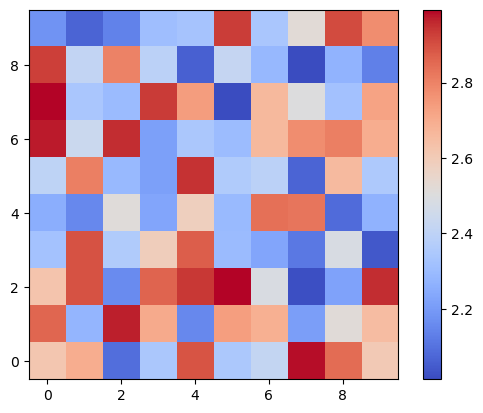

In [3]:
plt.imshow(Ec,origin='lower',cmap='coolwarm')
plt.colorbar()
plt.show()

In [4]:
model = sit.xymodel(Lx,Ly,Ej,Ec)

In [5]:
dt = model.find_GS(niter=4,stepsize=0.1)

/Users/jonathancurtis/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/jonathancurtis/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


In [6]:
print(dt)

29.06492519378662


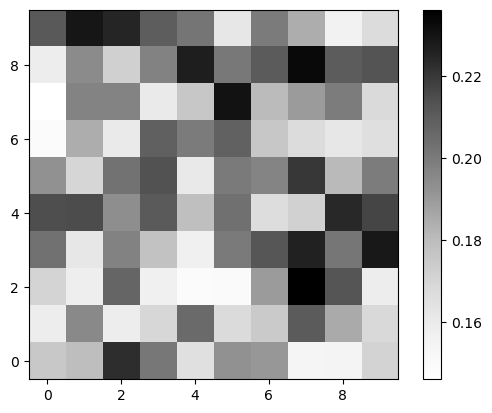

In [7]:
plt.imshow(sit.xymodel.charge_squared(model.gs_wf),origin='lower',cmap='Greys')
plt.colorbar()
plt.show()

In [8]:
flux = np.pi/4.

t0 = 0.
t1 = 5.
t2 = 2.*t1

nts = 200
times = np.linspace(t0,t2,nts)

model.quench_function = lambda t: 0. if (t<t0 or t>t2) else ( -flux if t>t1 else flux )

In [9]:
model.solve_eom_quench(times) 

In [10]:
c2_vs_ts = np.array([ model.charge_squared(model.wf_vs_t[...,t]) for t in range(nts)])
c2_vs_ts.shape

(200, 10, 10)

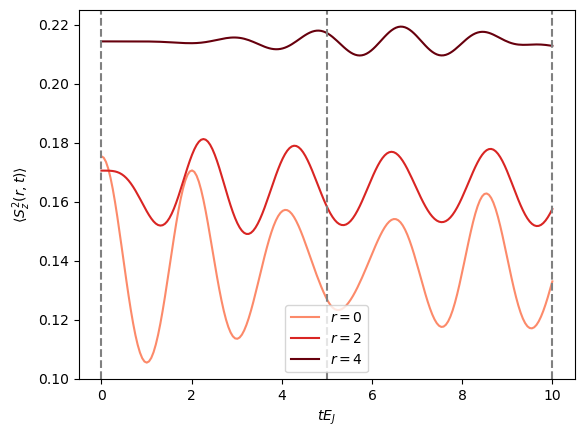

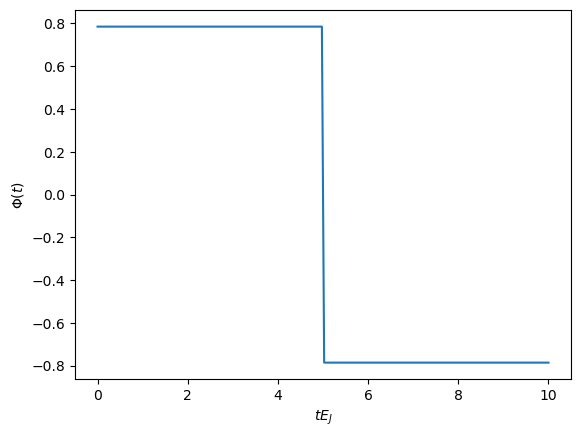

In [11]:
sites = [0,2,4]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for i in range(len(sites)):
    plt.plot(times,c2_vs_ts[:,sites[i],0],label=r'$r=$'+str(sites[i]),color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
plt.axvline(t0,linestyle='dashed',color='gray')
plt.axvline(t1,linestyle='dashed',color='gray')
plt.axvline(t2,linestyle='dashed',color='gray')
plt.legend()
plt.show()
plt.plot(times,np.array([ model.quench_function(t) for t in times ]) )
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\Phi(t)$')
plt.show()

In [46]:
Loschmidt_echo = np.array([ np.prod(sit.overlap(wf_vs_ts[0][...,0],wf_vs_ts[1][...,t])) for t in range(len(times)) ])

NameError: name 'wf_vs_ts' is not defined

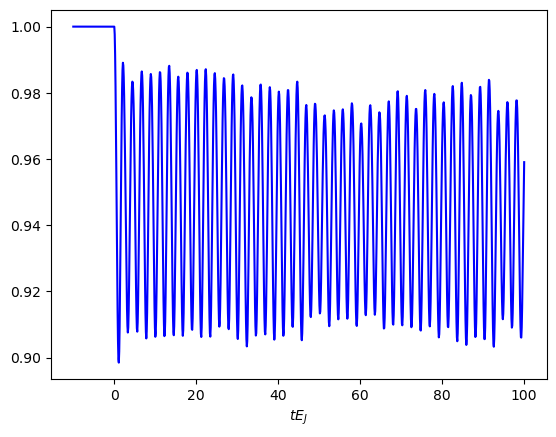

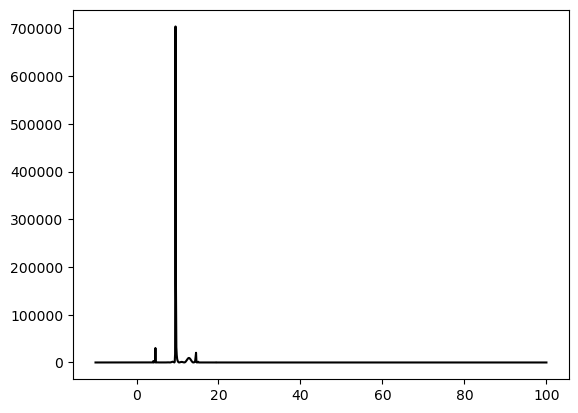

In [46]:
plt.plot(times,np.abs(Loschmidt_echo)**2,color='blue')
plt.xlabel(r'$tE_J$')
plt.show()

plt.plot(times,np.abs(np.fft.fft(Loschmidt_echo))**2,color='black')
#plt.yscale('log')
plt.show()




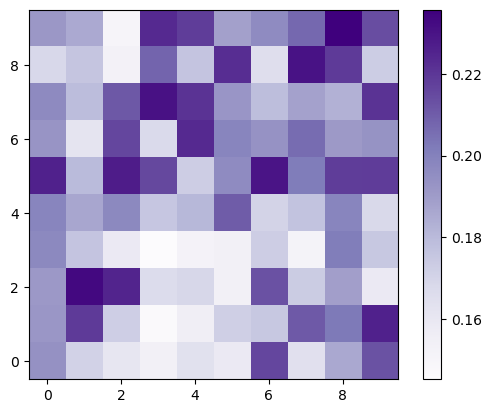

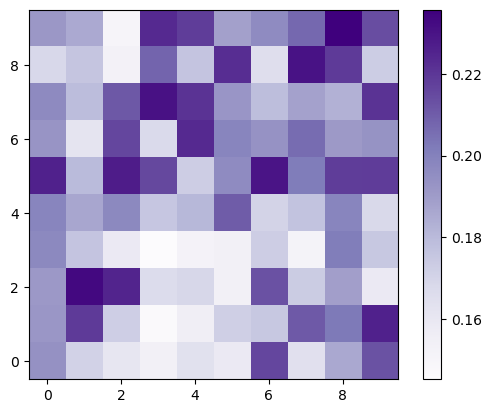

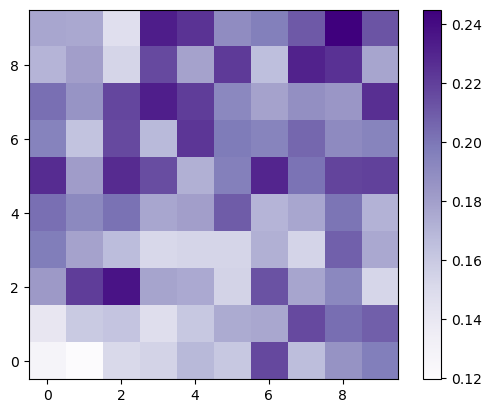

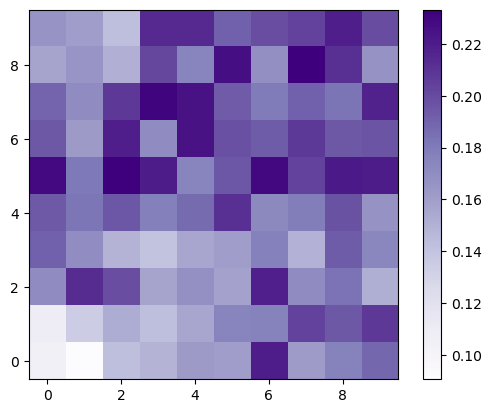

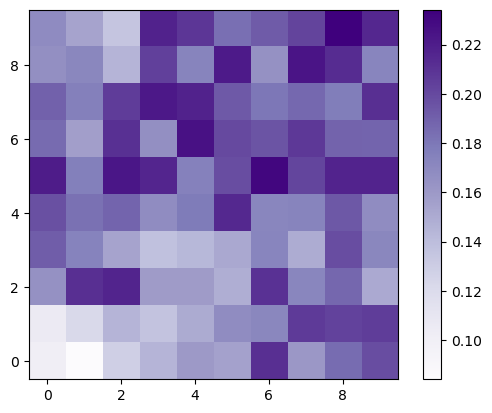

In [47]:
ts = [50,100,150,175,180]
for i in ts:
    plt.imshow(c2_vs_t[:,:,i],origin='lower',cmap='Purples')
    plt.colorbar()
    plt.show()


In [1]:
import QMC_square as qmc
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [2]:
EJ = 1.
EC = 0.01
T = 0.1
L = 10
M = 10

nburn = 10000
nsample = 1
nstep = 1
sim = qmc.QMC(EJ,EC,T,L,M)
sim.set_sampling(nburn,nsample,nstep)

sim.burn()
sim.sample()

    

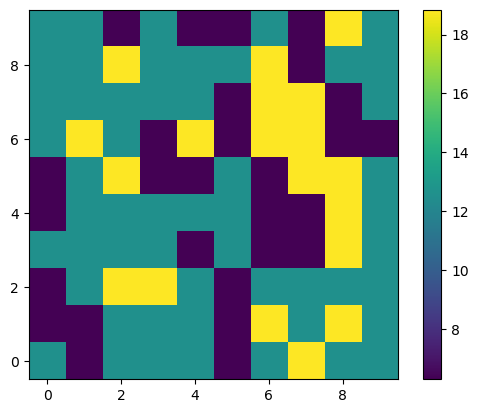

In [3]:
plt.imshow(sim.vort_samples[...,0,0],origin='lower')
plt.colorbar()
plt.show()